In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import os
import glob
import xarray as xr
from sklearn import preprocessing
import netCDF4 as nc
import matplotlib.pyplot as plt


np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

BASE = '/scratch/ab10313/pleiades/'
PATH_NN_surface = BASE+'NN_data_surface/'
PATH_NN_interior = BASE+'NN_data_interior/'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataloader

### Create input and output channels

In [3]:
# load preprocessed data into input and output channels



# X INPUT
grad_B = np.load(PATH_NN_surface+'grad_B.npy')
#FCOR = np.load(PATH_NN+'FCOR.npy')
TAU = np.load(PATH_NN_surface+'TAU.npy')
Q = np.load(PATH_NN_surface+'Q.npy')

X_input = np.stack([ grad_B, TAU, Q],axis=1)
print('X input shape:')
print( X_input.shape)
print('')


# Y OUTPUT
WB_sg = np.load(PATH_NN_interior+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN_interior+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN_interior+'WB_sg_std.npy')
              
Y_output = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2]) 
print('Y output shape:')
print(Y_output.shape)
print('')

np.isnan(X_input).any()
np.isnan(Y_output).any()

X input shape:
(8460, 3, 40, 40)

Y output shape:
(8460, 1, 40, 40)



False

### randomly generate train, test and validation sets

In [4]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random
time_ind = X_input.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.9
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%")
train_ind, test_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round((train_percent)*time_ind):]                                                                        

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train 90.0%, test 10.0%
no overlapping indecies


### defined train, test and val dataloaders

In [5]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


###### training dataset #######
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)

loader_train = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True
)
print('TRAIN')
print('X input shape:')
print( X_input[train_ind].shape)
print('Y output shape:')
print( Y_output[train_ind].shape)
print('')

###### test dataset #######
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_input[test_ind]).double(),
    torch.from_numpy(Y_output[test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST')
print('X input shape:')
print( X_input[test_ind].shape)
print('Y output shape:')
print( Y_output[test_ind].shape)
print('')



TRAIN
X input shape:
(7614, 3, 40, 40)
Y output shape:
(7614, 1, 40, 40)

TEST
X input shape:
(846, 3, 40, 40)
Y output shape:
(846, 1, 40, 40)



## CNN - direct fluxes 3 output channels

In [6]:
# define network structure in pytorch
import torch.nn.functional as FF

class CNN_direct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 15, padding='same', padding_mode='reflect')  # 7 inputs, 128 neurons for first hidden layer
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 15, padding='same', padding_mode='reflect')  # 128 inputs, 64 neurons for first hidden layer
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 48, 15, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv3_bn=nn.BatchNorm2d(48)  
        self.conv4 = nn.Conv2d(48, 32, 15, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv4_bn=nn.BatchNorm2d(32) 
        self.conv5 = nn.Conv2d(32, 16, 15, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv5_bn=nn.BatchNorm2d(16)  
        self.conv6 = nn.Conv2d(16, 8, 15, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv6_bn=nn.BatchNorm2d(8) 
        self.conv7 = nn.Conv2d(8, 1, 15, padding='same', padding_mode='reflect')  # 16 inputs, 1 neurons for first hidden layer
        self.conv7_bn=nn.BatchNorm2d(1) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
        x = self.conv6(x)
        x = F.relu(self.conv6_bn(x))
        x = self.conv7(x)
        x = self.conv7_bn(x)
        return x
 
    


## Train and test model: direct fluxes

In [10]:
# train network 
def train_model_direct(net, criterion, trainloader, optimizer, len_train_dataset, text="train"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(trainloader)}")
    
    net.train()
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
        nb = b_y.shape[0]
        train_loss = train_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    train_loss /= len_train_dataset  # dividing by the number of batches
    print(text + " loss:", train_loss)
    return train_loss


def test_model_direct(net, criterion, testloader, optimizer,len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss



def plot_model_direct(net, criterion, testloader, len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    #with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(
        testloader
    ):  # for each training step
        b_x = Variable(batch_x, requires_grad=True)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        nb = b_y.shape[0]
        test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    test_loss /= len_test_dataset  # dividing by the number of batches
    #         print(len(trainloader))
    print(text + " loss:", test_loss)
    return b_x, b_y, prediction


criterion = torch.nn.MSELoss()  # MSE loss function




## train CNN!

In [ ]:
torch.manual_seed(14)  # For reproducibility
cnn_submeso = CNN_direct().double()

n_epochs = 100  # Number of epocs could be increased
optimizer = optim.Adam(cnn_submeso.parameters(), lr=0.1)
test_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    print("epoch:", epoch)
    train_loss.append(train_model_direct(cnn_submeso, criterion, loader_train, optimizer,len(torch_dataset_train)))
    test_loss.append(test_model_direct(cnn_submeso, criterion, loader_test, optimizer,len(torch_dataset_test)))

torch.save(cnn_submeso, PATH_NN_surface+'cnn_7l_k15_surface_inputs.pth')

epoch: 1
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.9251381519855346
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.8633671682056694
epoch: 2
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.8857624898756262
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.858854634232585
epoch: 3
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.8751040266075224
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.8570222795050545
epoch: 4
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.8675190308667922
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.8643845242517458
epoch: 5
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.8556257707007157
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.8768897905043859
epoch: 6
Tr

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss[1:], "b", linewidth=3,label="training loss")
plt.plot(test_loss[1:], "lightblue",linewidth=3, label="test loss")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend();

In [ ]:
plt.savefig('./cnn_7l_k15_surface_inputs_loss.png')

In [47]:
cnn_submeso = torch.load(PATH_NN_surface+'cnn_7l_k5_surface_inputs.pth')


In [48]:
total_params = sum(
	param.numel() for param in cnn_submeso.parameters()
)
total_params


346691

In [49]:
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test,len(torch_dataset_test))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3084803222365302


In [39]:
# compare with FK
#WB_FK = np.load(PATH_NN+'WB_FK.npy')
#WB_FK_test = WB_FK[test_ind]

# compare with FK_Lf
#Lf_FK11 = np.load(PATH_NN+'Lf_FK11.npy')
#Lf_FK11_test = Lf_FK11[test_ind]

# compare with Bod_Lf
#Lf_BD23 = np.load(PATH_NN+'Lf_BD23.npy')
#Lf_BD23_test = Lf_BD23[test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 

In [18]:
from scipy import stats

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

corr_pred_wb = stats.pearsonr(cnn_submeso(b_x.to(device)).detach().cpu().numpy().flatten(), b_y.flatten())

print("correlation between prediction and target,  w'b':",corr_pred_wb )

correlation between prediction and target,  w'b': (0.8276855391967401, 0.0)


In [40]:
mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

Text(0.5, 0, '$\\overline{wb}^z$')

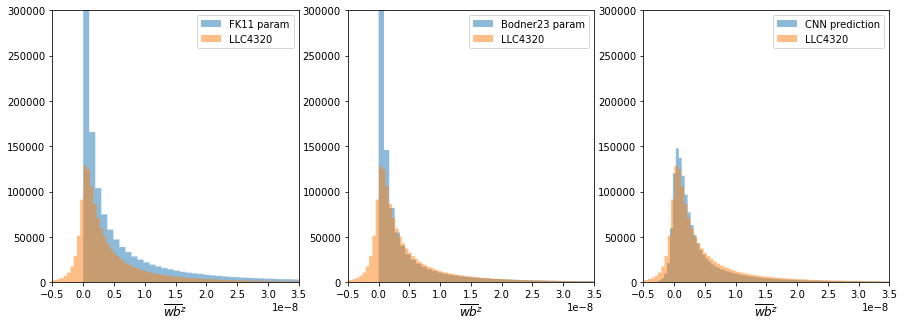

In [36]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plt.subplot(131)
_=plt.hist(((0.07*17e3/np.maximum(Lf_FK11_test[:],5000))*WB_FK_test[:]).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="FK11 param")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)

plt.subplot(132)
_=plt.hist(((0.07*17e3/np.maximum(Lf_BD23_test[:],5000))*WB_FK_test[:]).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="Bodner23 param")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)


plt.subplot(133)
_=plt.hist((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="CNN prediction")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)



#plt.savefig(BASE+'plots/cnn_prediction_hist.png')
#plt.xlabel('$\overline{wb}^z$')


Text(0.5, 0, '$\\overline{wb}^z$')

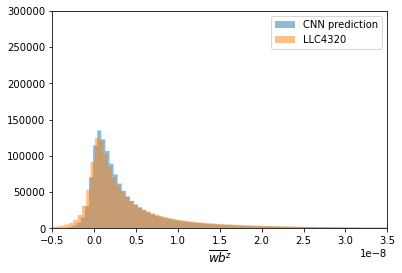

In [41]:
_=plt.hist((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="CNN prediction")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)

In [18]:
target_da = xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile), dims=["time", "axis", "i","j"])[:,0,:,:]
param_FK11_da = xr.DataArray((0.07*25e3/np.maximum(Lf_FK11_test[:],5000))*WB_FK_test[:], dims=["time", "i","j"])
param_BD23_da = xr.DataArray((0.07*25e3/np.maximum(Lf_BD23_test[:],5000))*WB_FK_test[:], dims=["time", "i","j"])
prediction_da = xr.DataArray((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile), dims=["time", "axis", "i","j"])[:,0,:,:]

In [19]:
import xrft

# target vs prediction spectra

WsBs_target_spectra = xrft.isotropic_power_spectrum(target_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_prediction_spectra = xrft.isotropic_power_spectrum(prediction_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_param_FK11_spectra = xrft.isotropic_power_spectrum(param_FK11_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_param_BD23_spectra = xrft.isotropic_power_spectrum(param_BD23_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')



/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be de

Text(0.5, 1.0, 'WsBs')

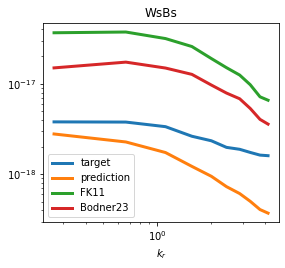

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 10))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(311)
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, 5e-3*WsBs_target_spectra.freq_r**-2, '--',linewidth=1.5,color='black', label='k^{-2}')
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, 2e-3*WsBs_target_spectra.freq_r**-3, '--',linewidth=1.5,color='gray', label='k^{-3}')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_target_spectra,linewidth=3, label='target')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_prediction_spectra,linewidth=3, label='prediction')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_param_FK11_spectra,linewidth=3, label='FK11')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_param_BD23_spectra,linewidth=3, label='Bodner23')
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_param_BD_spectra*WsBs_target_spectra.freq_r,linewidth=3, label='BD23')



plt.legend()
plt.xlabel('$k_r$')
#plt.ylabel('Normalized isotropic spectra')
plt.title('WsBs')
#plt.ylim([1e-3,1e-1])

# Better statistics

In [42]:
WB_sg = xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten())
WB_cnn = xr.DataArray((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile).flatten())

In [43]:
WB_sg.name = 'WB_subgrid'
WB_cnn.name = 'WB_cnn'

In [44]:
from xhistogram.xarray import histogram as xhist



xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()

Text(0, 0.5, '$CNN prediction$')

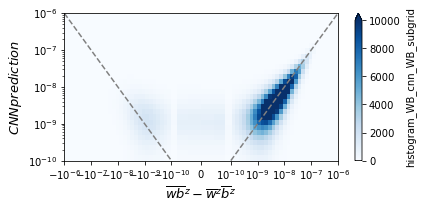

In [45]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_CNN.plot(ax=ax, vmax=10000, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
ax.set_ylabel(r"$CNN prediction$", 
              fontsize=13)

#plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCr-hist_region%02d.pdf' % reg))

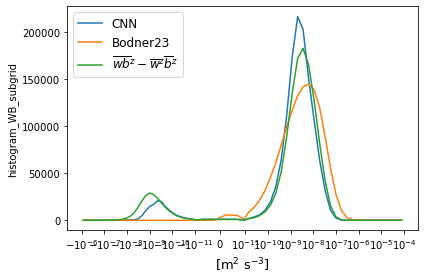

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

#xhist(WB_Bodner23_param, 
#      bins=[np.concatenate((-np.logspace(-6,-11,30),
#                            np.concatenate((np.linspace(-9e-12,9e-12,5),
#                                            np.logspace(-11,-4,30)))))
#           ]
     ).plot(ax=ax, label=r"Bodner23")
xhist(WB_cnn, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"CNN")
xhist(WB_FK11_param, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"Bodner23")
xhist(WB_sg, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$")
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
#plt.savefig(op.join(sdir,'Figs/eNATL60-wb-1Dhist_region%02d.pdf' % reg))

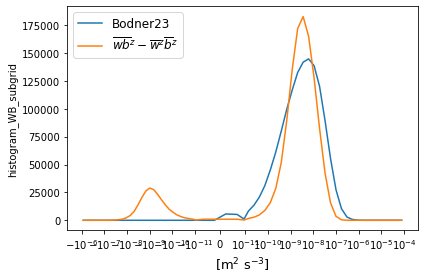

In [40]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

#xhist(WB_Bodner23_param, 
#      bins=[np.concatenate((-np.logspace(-6,-11,30),
#                            np.concatenate((np.linspace(-9e-12,9e-12,5),
#                                            np.logspace(-11,-4,30)))))
#           ]
#     ).plot(ax=ax, label=r"Bodner23")
#xhist(WB_cnn, 
#      bins=[np.concatenate((-np.logspace(-6,-11,30),
#                            np.concatenate((np.linspace(-9e-12,9e-12,5),
#                                            np.logspace(-11,-4,30)))))
#           ]
#     ).plot(ax=ax, label=r"CNN")
xhist(WB_FK11_param, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"Bodner23")
xhist(WB_sg, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$")
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
#plt.savefig(op.join(sdir,'Figs/eNATL60-wb-1Dhist_region%02d.pdf' % reg))